In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.ndimage import label, find_objects
from skimage.feature import hog
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from PIL import Image
import cv2

from utils import *

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
from xlstm import (
    xLSTMBlockStack,
    xLSTMBlockStackConfig,
    mLSTMBlockConfig,
    mLSTMLayerConfig,
    sLSTMBlockConfig,
    sLSTMLayerConfig,
    FeedForwardConfig,
)

In [2]:
base_path = 'arc-prize-2024/'

# Feature

In [3]:
from transformers import AutoImageProcessor, AutoModel, pipeline

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = AutoModel.from_pretrained("google/vit-base-patch16-224").to('cuda')
pipe = pipeline(task="image-feature-extraction", model_name="google/vit-base-patch16-384", device='cuda', pool=True)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/home/spoon/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No model was supplied, defaulted to google/vit-base-patch16-224 and revision 3f49326 (https://huggingface.co/google/vit-base-patch16-224).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def resize_and_convert_to_pil(array, target_size=(30, 30)):
    zoom_factors = (target_size[0] / array.shape[0], target_size[1] / array.shape[1])
    resized_array = zoom(array, zoom_factors, order=1)  # order=3 for cubic interpolation
    if resized_array.dtype != np.uint8:
        resized_array = (255 * (resized_array - np.min(resized_array)) / np.ptp(resized_array)).astype(np.uint8)
    pil_image = Image.fromarray(resized_array)
    return pil_image

In [5]:
def grid_embed(grid):
    resized_img = resize_and_convert_to_pil(grid)
    embeds = pipe([resized_img])[0][0]
    return np.array(embeds)

In [6]:
def extract_features(grid):
    features = []
    
    # Grid dimensions
    features.extend([len(grid), len(grid[0])])
    
    # Flatten the grid
    flattened = [cell for row in grid for cell in row]
    
    # Basic statistics
    features.extend([
        np.mean(flattened),
        np.median(flattened),
        np.max(flattened),
        np.min(flattened),
        np.std(flattened),
        np.sum(flattened),
    ])
    
    # Distribution
    unique, counts = np.unique(flattened, return_counts=True)
    color_distribution = dict(zip(unique, counts))
    
    # Ensure fixed length for counts
    max_unique_values = 10
    counts = counts[:max_unique_values]
    if len(counts) < max_unique_values:
        counts = np.pad(counts, (0, max_unique_values - len(counts)), 'constant')
    features.extend(counts)
    
    # Color diversity
    features.append(len(unique))
    
    # Dominant color
    dominant_color = unique[np.argmax(counts)]
    features.append(dominant_color)
    
    # Color transitions
    transitions = 0
    for i in range(len(grid)):
        for j in range(len(grid[0]) - 1):
            if grid[i][j] != grid[i][j + 1]:
                transitions += 1
    for j in range(len(grid[0])):
        for i in range(len(grid) - 1):
            if grid[i][j] != grid[i + 1][j]:
                transitions += 1
    features.append(transitions)
    
    # Symmetry features
    features.append(np.array_equal(grid, np.flipud(grid)))  # Vertical symmetry
    features.append(np.array_equal(grid, np.fliplr(grid)))  # Horizontal symmetry
    
    # Connected components
    from scipy.ndimage import label, find_objects
    labeled_grid, num_features = label(grid)
    features.append(num_features)
    
    # Entropy
    from scipy.stats import entropy
    features.append(entropy(counts))
    print('debug', len(features))

    # Spatial moments
    moments = cv2.moments(grid.astype(np.uint8))
    features.extend([moments['nu20'], moments['nu11'], moments['nu02']])
    
    # Distance to center
    center = np.array([len(grid) / 2, len(grid[0]) / 2])
    distances = [np.linalg.norm(np.array([i, j]) - center) for i in range(len(grid)) for j in range(len(grid[0])) if grid[i][j] != 0]
    features.append(np.mean(distances) if distances else 0)
    
    # Spatial density in quadrants
    quadrants = [
        grid[:len(grid)//2, :len(grid[0])//2],
        grid[:len(grid)//2, len(grid[0])//2:],
        grid[len(grid)//2:, :len(grid[0])//2],
        grid[len(grid)//2:, len(grid[0])//2:]
    ]
    for quadrant in quadrants:
        features.append(np.sum(quadrant != 0) / quadrant.size)
    
    # Edge density
    edges = np.sum(grid[:, :-1] != grid[:, 1:]) + np.sum(grid[:-1, :] != grid[1:, :])
    features.append(edges / grid.size)
    
    # Edge Detection Features
    from scipy.ndimage import sobel
    sobel_x = sobel(grid, axis=0)
    sobel_y = sobel(grid, axis=1)
    sobel_edges = np.hypot(sobel_x, sobel_y)
    features.extend([
        np.mean(sobel_edges),
        np.std(sobel_edges),
        np.max(sobel_edges),
        np.min(sobel_edges)
    ])
    
    # Texture Features (Local Binary Patterns)
    from skimage.feature import local_binary_pattern
    lbp = local_binary_pattern(grid, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    
    # Ensure fixed length for LBP histogram
    lbp_hist_length = 9
    lbp_hist = lbp_hist[:lbp_hist_length]
    if len(lbp_hist) < lbp_hist_length:
        lbp_hist = np.pad(lbp_hist, (0, lbp_hist_length - len(lbp_hist)), 'constant')
    features.extend(lbp_hist)
    
    # Shape Features (Hu Moments)
    moments = cv2.moments(grid.astype(np.uint8))
    hu_moments = cv2.HuMoments(moments).flatten()
    features.extend(hu_moments)
    
    # HOG Features
    from skimage.feature import hog
    hog_features = hog(grid, pixels_per_cell=(2, 2), cells_per_block=(1, 1), feature_vector=True)
    
    # Ensure fixed length for HOG features
    hog_length = 36  # Example length, adjust based on your needs
    hog_features = hog_features[:hog_length]
    if len(hog_features) < hog_length:
        hog_features = np.pad(hog_features, (0, hog_length - len(hog_features)), 'constant')
    features.extend(hog_features)
    
    # Debug: Print the shape of the feature vector
    print(f"Feature vector length: {len(features)}")

    # embeds = grid_embed(grid)
    # features.extend(embeds)
    
    return np.array(features)
   

In [7]:
def prepare_data(input_grids, output_grids):
    print('feature extraction..')
    MAX_SIZE = 30
    X = []
    for grid in input_grids:
        zoom_factors = (MAX_SIZE / len(grid), MAX_SIZE / len(grid[0]))
        grid = zoom(grid, zoom_factors, order=1)
        data = extract_features(grid)
        X.append(data)
    X = np.array(X)
    y = np.full((len(output_grids), MAX_SIZE, MAX_SIZE), -100)
    for i, grid in enumerate(output_grids):
        h, w = len(grid), len(grid[0])
        y[i, :h, :w] = grid
    
    return X, y

In [8]:
def load_arc_data(base_path, training_challenges):
    data = {}
    for key, task in training_challenges.items():
        data_in = [np.array(example['input']) for example in task['train']]
        data_out = [np.array(example['output']) for example in task['train']]
        data[key] = (data_in, data_out)

    return data

In [140]:
class ARCDataset(Dataset):
    def __init__(self, inputs, outputs, key):        
        # Load the data
        self.inputs = inputs
        self.outputs = outputs
        self.key = key

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Convert input and output grids to tensors
        input_grid = torch.tensor(self.inputs[idx], dtype=torch.float32)
        output_grid = torch.tensor(self.outputs[idx], dtype=torch.float32)
        
        return {
            'task_key': self.key,
            'input': input_grid,
            'output': output_grid,
            'input_shape': input_grid.shape,
            'output_shape': output_grid.shape
        }

In [139]:
class GridxLSTM(nn.Module):
    def __init__(self, max_input_grid_size=30, max_output_grid_size=30, embedding_dim=128, output_channels=1):
        super().__init__()
        
        self.max_input_grid_size = max_input_grid_size
        self.max_output_grid_size = max_output_grid_size
        self.embedding_dim = embedding_dim
        self.output_channels = output_channels
        
        cfg = xLSTMBlockStackConfig(
            mlstm_block=mLSTMBlockConfig(
                mlstm=mLSTMLayerConfig(
                    conv1d_kernel_size=4, qkv_proj_blocksize=4, num_heads=4
                )
            ),
            slstm_block=sLSTMBlockConfig(
                slstm=sLSTMLayerConfig(
                    backend="cuda",
                    num_heads=4,
                    conv1d_kernel_size=4,
                    bias_init="powerlaw_blockdependent",
                ),
                feedforward=FeedForwardConfig(proj_factor=1.3, act_fn="gelu"),
            ),
            context_length=max_input_grid_size**2,
            num_blocks=7,
            embedding_dim=embedding_dim,
            slstm_at=[1],
        )
        
        self.xlstm_stack = xLSTMBlockStack(cfg)
        self.input_positional_encoding = self.create_positional_encoding(max_input_grid_size)
        self.output_positional_encoding = self.create_positional_encoding(max_output_grid_size)
        self.input_proj = nn.Linear(1, embedding_dim)
        self.output_proj = nn.Linear(embedding_dim, output_channels)
        
    def create_positional_encoding(self, max_grid_size):
        pos_encoding = torch.zeros(max_grid_size, max_grid_size, self.embedding_dim)
        position = torch.arange(max_grid_size).unsqueeze(1).repeat(1, max_grid_size).view(-1)
        div_term = torch.exp(torch.arange(0, self.embedding_dim, 2).float() * -(torch.log(torch.tensor(10000.0)) / self.embedding_dim))
        
        pe_sin = torch.sin(position.unsqueeze(1) * div_term)
        pe_cos = torch.cos(position.unsqueeze(1) * div_term)
        
        pos_encoding[:, :, 0::2] = pe_sin.view(max_grid_size, max_grid_size, -1)
        pos_encoding[:, :, 1::2] = pe_cos.view(max_grid_size, max_grid_size, -1)
        
        return nn.Parameter(pos_encoding, requires_grad=False)
         
    def forward(self, x):
        batch_size, input_height, input_width = x.shape
        
        # Project input to embedding dimension
        x = self.input_proj(x.unsqueeze(-1))
        
        # Add input positional encoding
        x = x + self.input_positional_encoding[:input_height, :input_width, :]
        
        # Reshape for xLSTM
        x_flat = x.view(batch_size, -1, self.embedding_dim)
        
        # Pad to max length
        x_padded = nn.functional.pad(x_flat, (0, 0, 0, self.max_input_grid_size**2 - input_height*input_width))
        
        # Process with xLSTM
        output = self.xlstm_stack(x_padded)
        
        # Reshape output to max_output_grid_size
        output = output[:, :self.max_output_grid_size**2, :]
        output = output.view(batch_size, self.max_output_grid_size, self.max_output_grid_size, self.embedding_dim)
        
        # Add output positional encoding
        output = output + self.output_positional_encoding[:self.max_output_grid_size, :self.max_output_grid_size, :].unsqueeze(0).expand(batch_size, -1, -1, -1)
        
        # Project to output channels
        output = self.output_proj(output)
        
        # Pad output for training with -100
        output_padded = nn.functional.pad(output, (0, 0, 0, self.max_output_grid_size - output.shape[2], 0, self.max_output_grid_size - output.shape[1]), value=-100)
        
        return output_padded
# Usage example
model = GridxLSTM(max_input_grid_size=30, max_output_grid_size=30, embedding_dim=128, output_channels=1).to('cuda')

# Example input (batch_size, height, width)
x = torch.randn(4, 20, 15).to('cuda')
output = model(x)

print(f"Output shape: {output.shape}")

Output shape: torch.Size([4, 30, 30, 1])


In [193]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    
    for batch in dataloader:
        input_grid = batch['input'].to(device)
        target_output = batch['output'].to(device)
        
        optimizer.zero_grad()
        
        pred_grid = model(input_grid)
        
        # Pad target_output to max_output_grid_size with -100
        target_height, target_width = target_output.shape[1:3]
        target_output_padded = nn.functional.pad(target_output, (0, model.max_output_grid_size - target_width, 0, model.max_output_grid_size - target_height), value=-100)
        
        # Mask for valid values (not -100)
        mask = target_output_padded != -100
        
        # Apply mask to predictions and target
        pred_grid_masked = pred_grid[mask]
        target_output_masked = target_output_padded[mask]
        
        # Ensure the shapes match
        pred_grid_masked = pred_grid_masked.view(-1)
        target_output_masked = target_output_masked.view(-1)
        
        # Grid prediction loss
        grid_loss = criterion(pred_grid_masked, target_output_masked)
        
        grid_loss.backward()
        optimizer.step()
        
        total_loss += grid_loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

# Training and Result

In [170]:
def load_arc_data(training_challenges, training_challenges_sol):
    data = {}
    for key, task in training_challenges.items():
        data_in = [np.array(example['input']) for example in task['train']]
        data_out = [np.array(example['output']) for example in task['train']]
        problem = training_challenges[key]['test'][0]['input']
        solution = training_challenges_sol[key][0]
        data[key] = {
            'training_data': data_in, 
            'training_label': data_out, 
            'test_input': problem, 
            'test_output': solution,
            'task_key': key
        }

    return data

In [171]:
training_challenge_sol = load_json(base_path + 'arc-agi_training_solutions.json')
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
load_arc_train_test = load_arc_data(training_challenges, training_challenge_sol)

In [304]:
import random
task_name = random.choice(list(load_arc_train_test.keys()))
# task_name = 'e3497940'
task_name

'007bbfb7'

In [305]:
sample_task = load_arc_train_test[task_name]

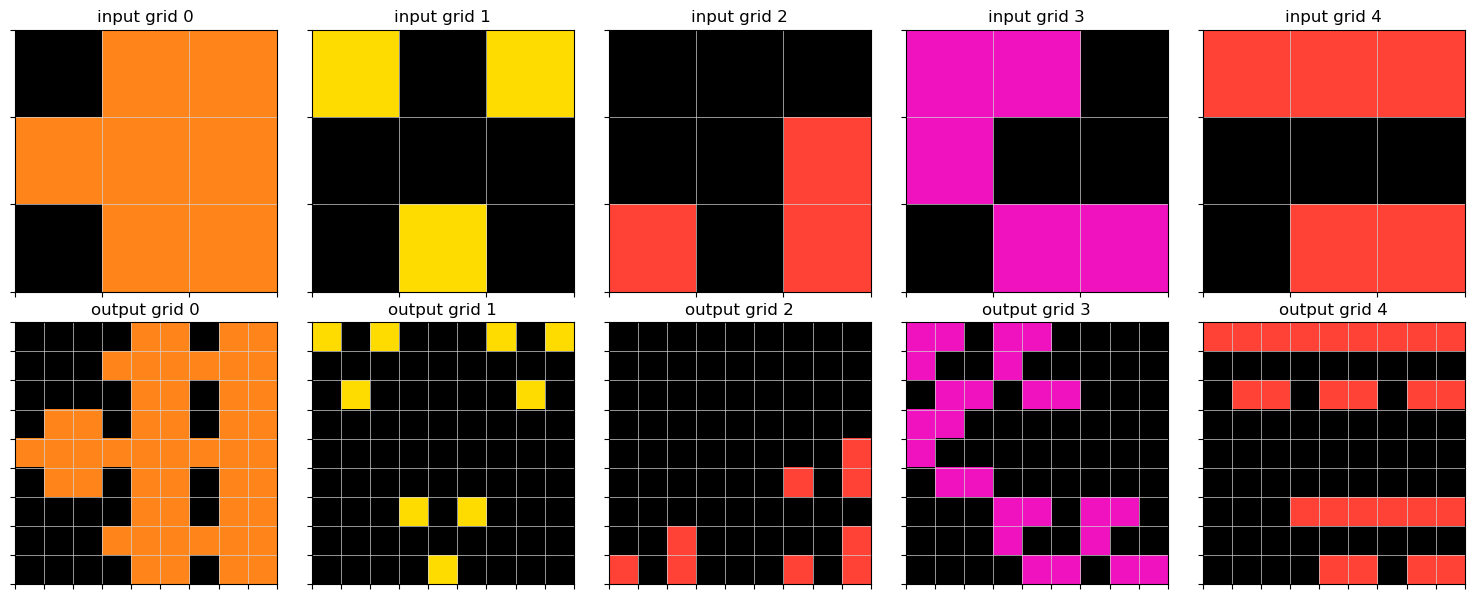

In [306]:
%matplotlib inline
plot_grids(sample_task['training_data'], 
           sample_task['training_label'], 
           list(map(lambda x: f'input grid {x}', range(len(sample_task['training_data'])))), 
           list(map(lambda x: f'output grid {x}', range(len(sample_task['training_data'])))))
plt.show()

In [307]:
# Prepare data
X, y = prepare_data(sample_task['training_data'], sample_task['training_label'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)

feature extraction..
debug 25
Feature vector length: 90
debug 25
Feature vector length: 90
debug 25
Feature vector length: 90
debug 25
Feature vector length: 90
debug 25
Feature vector length: 90


In [308]:
X_train_pca

array([[-7.47132558,  2.56597644, -3.4455828 ,  0.70765773],
       [ 0.90410381,  3.90599442,  3.97700629, -1.58603384],
       [ 7.62464691, -0.71792017, -3.43614252, -1.72093181],
       [-4.77705402, -5.00391064,  1.64108758, -1.19742225],
       [ 3.71962888, -0.75014005,  1.26363145,  3.79673017]])

In [309]:
# dataset = ARCDataset(sample_task['training_data'], sample_task['training_label'], sample_task['task_key'])
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [326]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=150, max_depth=2, gamma=0.0)
# model.fit(X_train_scaled, y.reshape(y.shape[0], -1))
model.fit(X_train_pca, y.reshape(y.shape[0], -1))
# Analyze feature importances

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [327]:
# # Training loop
# num_epochs = 100
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train_size = int(0.8 * len(dataset))
# val_size = len(dataset) - train_size
# dataset = ARCDataset(sample_task['training_data'], sample_task['training_label'], sample_task['task_key'])
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# # Initialize model, loss function, and optimizer
# model_lstm = GridxLSTM(max_input_grid_size=30, max_output_grid_size=30, embedding_dim=256, output_channels=1).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

# for epoch in range(num_epochs):
#     train_loss = train(model_lstm, train_dataloader, criterion, optimizer, device)
    
#     # Update tqdm postfix with train and val losses
#     if epoch % 10 == 0:
#         print(train_loss)

# print("Training completed!")

In [328]:
# test_input = torch.tensor(sample_task['test_input']).unsqueeze(0).to('cuda').float()
# test_output = model_lstm(test_input)

In [329]:
# plot_single_grid(test_output.detach().cpu().numpy().reshape(30, 30))

In [330]:
x_test, y_test = sample_task['test_input'], sample_task['test_output']

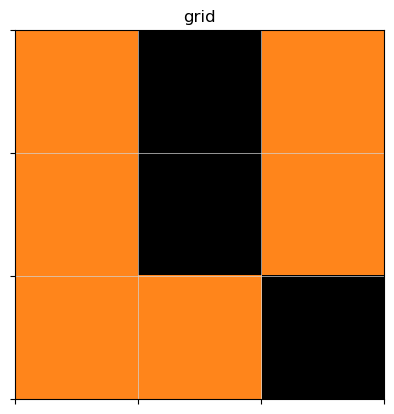

In [331]:
plot_single_grid(x_test)

In [332]:
def max_row_width(arr):
    max_width = 0
    for row in arr:
        valid_indices = np.where(row >= 0)[0]
        if valid_indices.size > 0:
            width = valid_indices[-1] + 1
            if width > max_width:
                max_width = width
    return max_width

def max_col_height(arr):
    max_height = 0
    for col in arr.T:  # Transpose the array to iterate over columns
        valid_indices = np.where(col >= 0)[0]
        if valid_indices.size > 0:
            height = valid_indices[-1] + 1
            if height > max_height:
                max_height = height
    return max_height

def trim_grid(arr):
    max_width = max_row_width(arr)
    max_height = max_col_height(arr)
    return arr[:max_height, :max_width]

In [333]:
x_test = np.array(x_test)
x_reshaped = extract_features(x_test).reshape(1,-1)
x_scaled = scaler.transform(x_reshaped)
x_pca = pca.transform(x_scaled)
pred = model.predict(x_pca).reshape(30, 30).astype(int)
# pred = model.predict(x_scaled).reshape(30, 30).astype(int)

debug 25
Feature vector length: 90


test prediction


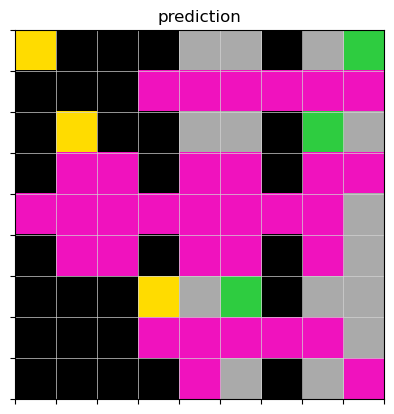

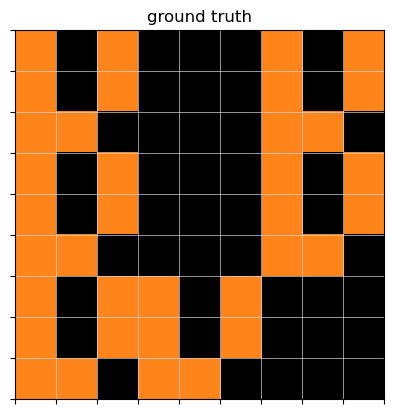

In [334]:
print('test prediction')
plot_single_grid(trim_grid(pred), 'prediction')
plot_single_grid(y_test, 'ground truth')